In [1]:
import pandas as pd
import numpy as np
import xlsxwriter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read in data
df = pd.read_csv('/Users/maxnoordhoekhegt/Documents/QTEM/QDC/GBACDutchieVita/Premi_ClubQ8.csv', sep = ';', decimal=",")

#split date and time
df[['REQUEST_DATE','REQUEST_TIME']] = df.DATA_OPERAZIONE.str.split(" ",expand=True,)
#drop the original column
df = df.drop(columns="DATA_OPERAZIONE")
#rename columns
df.columns = ['CUSTOMER_CODE', 'REQUEST_PLACE', 'CATEGORY', 'MATERIAL_GROUPING', 'PRIZE_DESCRIPTION', 'POINTS_REQUIRED', 'CUSTOMER_CONTRIBUTION', 'DATE', 'TIME']
#convert contribution to float
df['CUSTOMER_CONTRIBUTION'] = df['CUSTOMER_CONTRIBUTION'].astype(float)

df

,CUSTOMER_CODE,REQUEST_PLACE,CATEGORY,MATERIAL_GROUPING,PRIZE_DESCRIPTION,POINTS_REQUIRED,CUSTOMER_CONTRIBUTION,DATE,TIME
0,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:16:21
1,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:17:30
2,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:18:49
3,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:19:42
4,7071161603014051338,PUNTO VENDITA,PREMIO FISICO,PER TE,PRENOTAZIONE PORTA CARTE CREDITO SPARCO,450.0,0.0,2020-09-01,00:34:24
...,...,...,...,...,...,...,...,...,...
501444,7071161603014068530,PUNTO VENDITA,PREMIO FISICO,ELETTRODOMESTICI,PRENOTAZIONE PHILIPS RASOIO,2395.0,0.0,2021-08-31,23:14:00
501445,7071161603670271808,PUNTO VENDITA,PREMIO FISICO,MODA,PRENOTAZIONE OROLOGIO SECTOR,3500.0,30.0,2021-08-31,23:14:59
501446,7071161603014068530,PUNTO VENDITA,PREMIO FISICO,ELETTRONICA,PRENOTAZIONE AVVITATORE,4200.0,15.0,2021-08-31,23:15:02
501447,7071161603007816325,PUNTO VENDITA,PREMIO FISICO,CASA,PRENOTAZIONE PORTABIANCHERIA,4175.0,0.0,2021-08-31,23:24:29


The dataset has 501449 rows and 9 columns. 

In [3]:
#define a function that counts the number of na's and gives also the percentage of total observations in a column that is na
def summarize_na(df: pd.DataFrame) -> pd.DataFrame:
    nan_count = df.isna().sum()
    return pd.DataFrame({'nan_count': nan_count, 
                         'nan_pct': nan_count / len(df) * 100
                         }
                        )[nan_count > 0]

In [4]:
#look at the number of na's for different columns
df_nan_sum = summarize_na(df)
df_nan_sum

,nan_count,nan_pct
POINTS_REQUIRED,229,0.045668
CUSTOMER_CONTRIBUTION,37895,7.557100


In [5]:
#finding the unique levels of the factor variable category
df['CATEGORY'].unique()

array(['PREMIO FISICO', 'BUONO SCONTO CARBURANTE'], dtype=object)

In [6]:
def get_frequencies(series: pd.Series, n_categories: int = None, 
                    bins: int = None, dropna: bool = True
                    ) -> pd.DataFrame:
    """Return a DataFrame displaying the series frequencies.
    
    Parameters
    ----------
    series: pd.Series
        The series for which frequencies are to be computed.
    n_categories: int, optional
        Maximum number of categories to return in output.
        Low-frequency categories will be grouped together to
        reach this threshold.
        
    """
    vc = series.value_counts(ascending=False, 
                             bins=bins, 
                             dropna=dropna
                             )
    if n_categories is not None:
        if not isinstance(n_categories, int) or n_categories <= 0:
            raise TypeError('n_categories should be a strictly positive integer')
        if n_categories < len(vc):
            freq_others = vc.iloc[n_categories - 1:].sum()
            vc = vc.iloc[:n_categories - 1]\
                   .append(pd.Series({'others': freq_others}))
    return pd.DataFrame({'absolute': vc, 
                         'relative': vc / len(series),
                         },
                        index=vc.index
                        )

In [7]:
# what is the proportion of transactions for prizes that has been done online compared to physcial
get_frequencies(df['REQUEST_PLACE'], n_categories=5)

,absolute,relative
PUNTO VENDITA,469059,0.935407
ONLINE,32390,0.064593


In [8]:
#this shows the difference in type of prize that customers obtained
get_frequencies(df['CATEGORY'], n_categories=5)

,absolute,relative
BUONO SCONTO CARBURANTE,272660,0.543744
PREMIO FISICO,228789,0.456256


In [9]:
#make an overview of the different groups of prizes and the proportion of occurence
get_frequencies(df['MATERIAL_GROUPING'], n_categories=20)

,absolute,relative
BUONO SCONTO CARBURANTE,272660,0.543744
PER LA TUA CASA,68450,0.136504
PER TE,30569,0.060961
ELETTRONICA,24924,0.049704
TAVOLA & CUCINA,20407,0.040696
CASA,18529,0.036951
ELETTRODOMESTICI,17489,0.034877
PER IL TUO BENESSERE,14858,0.029630
TEMPO LIBERO,9569,0.019083
MODA,7237,0.014432


In [10]:

#overview of all the awarded prizes in the dataset along with proportion of total that they got awarded
get_frequencies(df['PRIZE_DESCRIPTION'], n_categories=5)

,absolute,relative
BUONO SCONTO CARB 4E 430 PUNTI,88550,0.176588
BUONO SCONTO CARB 4E 860 PUNTI,70302,0.140198
BUONO SCONTO CARB 4E 1290 PUNTI,66117,0.131852
BUONO SCONTO CARB 4E 2580 PUNTI,47553,0.094831
others,228927,0.456531


In [11]:
# proportions of different levels of required points in the transaction
get_frequencies(df['POINTS_REQUIRED'], n_categories=5)

,absolute,relative
430.0,272660,0.543744
650.0,48678,0.097075
350.0,19034,0.037958
390.0,11792,0.023516
others,149056,0.297251


In [12]:
#proportion of different contribution levels
get_frequencies(df['CUSTOMER_CONTRIBUTION'], n_categories=5)

,absolute,relative
0.0,389550,0.776849
5.0,13449,0.026820
2.0,7262,0.014482
8.0,6811,0.013583
others,46482,0.092695


In [13]:
#proportion of transactions of the total that are performed on each day
get_frequencies(df['DATE'], n_categories=5)

,absolute,relative
2021-03-15,2765,0.005514
2020-09-30,2158,0.004304
2021-03-31,2150,0.004288
2021-03-26,2129,0.004246
others,492247,0.981649


In [14]:
#we read in the customer database
df2 = pd.read_csv('/Users/maxnoordhoekhegt/Documents/QTEM/QDC/GBACDutchieVita/Anagrafica_ClubQ8.csv', sep = ';', decimal=",")

#copy the date column
df2['DATE_JOINED'] = df2['DATA_BATTESIMO']
#drop the original
df2 = df2.drop(columns="DATA_BATTESIMO")
#rename all the columns
df2.columns = ['CUSTOMER_CODE', 'SEX', 'DOB', 'REGION', 'PROVINCE', 'CITY', 'TYPE_OF_CARD' ,'TOTAL_POINTS', 'DATE_JOINED']

df2

,CUSTOMER_CODE,SEX,DOB,REGION,PROVINCE,CITY,TYPE_OF_CARD,TOTAL_POINTS,DATE_JOINED
0,7071161603018922195,M,1951-09-14 00:00:00,LAZIO,VITERBO,SUTRI,STARQ8_FISICA,511.0,2015-01-08 12:32:58
1,7071161603005992565,F,1988-09-15 00:00:00,NaN,NaN,NaN,STARQ8_FISICA,379.0,2020-07-10 12:22:35
2,7071161603025867243,F,1943-09-09 00:00:00,LAZIO,ROMA,ROMA,STARQ8_FISICA,108.0,2020-07-10 18:07:14
3,7071161603021997861,M,1974-03-01 00:00:00,SICILIA,MESSINA,MESSINA,STARQ8_FISICA,100.0,2020-07-10 18:08:21
4,7071161603025554049,M,1963-11-22 00:00:00,CAMPANIA,SALERNO,EBOLI,STARQ8_FISICA,284.0,2020-07-10 18:09:27
...,...,...,...,...,...,...,...,...,...
1656132,7071161603672630225,F,1962-06-22 00:00:00,EMILIA ROMAGNA,RIMINI,SAN GIOVANNI IN MARIGNANO,STARQ8_FISICA,2741.0,2019-11-27 18:06:31
1656133,7071161603673015798,M,1967-03-19 00:00:00,LAZIO,ROMA,ROMA,STARQ8_FISICA,8996.0,2019-03-21 08:34:30
1656134,7071161603024035909,M,1987-03-18 00:00:00,SICILIA,PALERMO,PALERMO,STARQ8_FISICA,424.0,2021-01-19 09:07:37
1656135,7071161603601002132,F,1984-09-20 00:00:00,LOMBARDIA,BRESCIA,ISEO,STARQ8_VIRTUALE,740.0,2020-12-15 22:57:21


In [15]:
#merge the prizes database with the customer database
df = pd.merge(df, df2, how = 'left')
df

,CUSTOMER_CODE,REQUEST_PLACE,CATEGORY,MATERIAL_GROUPING,PRIZE_DESCRIPTION,POINTS_REQUIRED,CUSTOMER_CONTRIBUTION,DATE,TIME,SEX,DOB,REGION,PROVINCE,CITY,TYPE_OF_CARD,TOTAL_POINTS,DATE_JOINED
0,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:16:21,M,1978-09-28 00:00:00,SICILIA,MESSINA,MESSINA,STARQ8_FISICA,3997.0,2013-05-13 09:16:29
1,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:17:30,M,1978-09-28 00:00:00,SICILIA,MESSINA,MESSINA,STARQ8_FISICA,3997.0,2013-05-13 09:16:29
2,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:18:49,M,1978-09-28 00:00:00,SICILIA,MESSINA,MESSINA,STARQ8_FISICA,3997.0,2013-05-13 09:16:29
3,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:19:42,M,1978-09-28 00:00:00,SICILIA,MESSINA,MESSINA,STARQ8_FISICA,3997.0,2013-05-13 09:16:29
4,7071161603014051338,PUNTO VENDITA,PREMIO FISICO,PER TE,PRENOTAZIONE PORTA CARTE CREDITO SPARCO,450.0,0.0,2020-09-01,00:34:24,M,1967-09-02 00:00:00,SICILIA,PALERMO,CEFALU',STARQ8_FISICA,5279.0,2001-10-05 11:34:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501444,7071161603014068530,PUNTO VENDITA,PREMIO FISICO,ELETTRODOMESTICI,PRENOTAZIONE PHILIPS RASOIO,2395.0,0.0,2021-08-31,23:14:00,M,1975-07-11 00:00:00,NaN,NaN,NaN,STARQ8_FISICA,111.0,2017-07-04 13:00:40
501445,7071161603670271808,PUNTO VENDITA,PREMIO FISICO,MODA,PRENOTAZIONE OROLOGIO SECTOR,3500.0,30.0,2021-08-31,23:14:59,M,1977-11-29 00:00:00,CAMPANIA,NAPOLI,NAPOLI,STARQ8_FISICA,9590.0,2012-11-08 10:28:34
501446,7071161603014068530,PUNTO VENDITA,PREMIO FISICO,ELETTRONICA,PRENOTAZIONE AVVITATORE,4200.0,15.0,2021-08-31,23:15:02,M,1975-07-11 00:00:00,NaN,NaN,NaN,STARQ8_FISICA,111.0,2017-07-04 13:00:40
501447,7071161603007816325,PUNTO VENDITA,PREMIO FISICO,CASA,PRENOTAZIONE PORTABIANCHERIA,4175.0,0.0,2021-08-31,23:24:29,M,1967-11-13 00:00:00,MARCHE,ANCONA,ANCONA,STARQ8_FISICA,1041.0,2015-08-28 15:56:15


In [29]:
dfdob = df[['TOTAL_POINTS','POINTS_REQUIRED','CUSTOMER_CONTRIBUTION','DOB']].copy()
dfdob

,TOTAL_POINTS,POINTS_REQUIRED,CUSTOMER_CONTRIBUTION,DOB
0,3997.0,1800.0,NaN,1978-09-28 00:00:00
1,3997.0,1800.0,NaN,1978-09-28 00:00:00
2,3997.0,1800.0,NaN,1978-09-28 00:00:00
3,3997.0,1800.0,NaN,1978-09-28 00:00:00
4,5279.0,450.0,0.0,1967-09-02 00:00:00
...,...,...,...,...
501444,111.0,2395.0,0.0,1975-07-11 00:00:00
501445,9590.0,3500.0,30.0,1977-11-29 00:00:00
501446,111.0,4200.0,15.0,1975-07-11 00:00:00
501447,1041.0,4175.0,0.0,1967-11-13 00:00:00


In [34]:
dfdob['CUSTOMER_CONTRIBUTION*1000'] = dfdob['CUSTOMER_CONTRIBUTION']*1000

In [31]:
dfdob[['Year','Month','Day']] = dfdob.DOB.str.split("-",expand=True,)

In [37]:
dfdob = dfdob['TOTAL_POINTS','POINTS_REQUIRED','CUSTOMER_CONTRIBUTION*1000','DOB']
dfdob

KeyError: ('TOTAL_POINTS', 'POINTS_REQUIRED', 'CUSTOMER_CONTRIBUTION*1000', 'DOB')

In [38]:
dfdob = dfdob.groupby(['Year']).mean()
dfdob

,TOTAL_POINTS,POINTS_REQUIRED,CUSTOMER_CONTRIBUTION,CUSTOMER_CONTRIBUTION*1000
Year,,,,
1901,3828.000000,430.000000,0.000000,0.000000
1903,98.500000,375.000000,0.000000,0.000000
1904,972.250000,645.000000,0.000000,0.000000
1906,440.500000,430.000000,0.000000,0.000000
1920,705.521739,837.391304,3.434783,3434.782609
...,...,...,...,...
2003,627.771930,473.684211,0.303571,303.571429
2004,1522.000000,430.000000,0.000000,0.000000
2005,142.000000,1603.846154,NaN,NaN


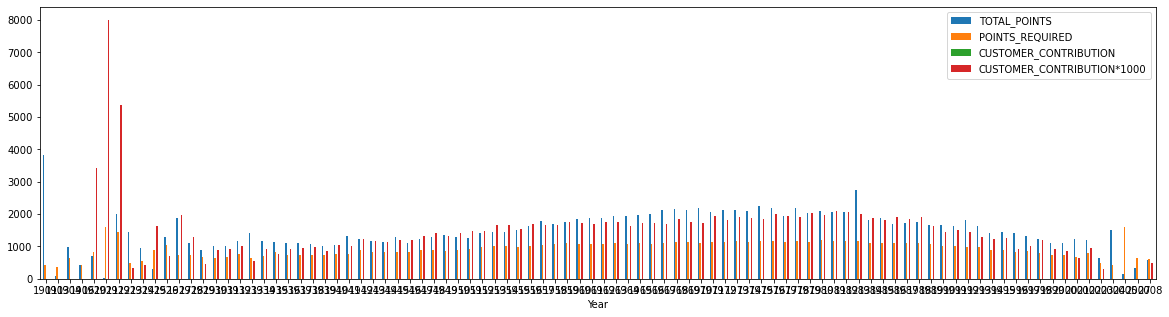

In [40]:
DOB = dfdob.plot.bar(rot=0,figsize=(20, 5))

In [16]:
dfmonth = df[['TOTAL_POINTS','POINTS_REQUIRED','CUSTOMER_CONTRIBUTION','DATE']].copy()
dfmonth

,TOTAL_POINTS,POINTS_REQUIRED,CUSTOMER_CONTRIBUTION,DATE
0,3997.0,1800.0,NaN,2020-09-01
1,3997.0,1800.0,NaN,2020-09-01
2,3997.0,1800.0,NaN,2020-09-01
3,3997.0,1800.0,NaN,2020-09-01
4,5279.0,450.0,0.0,2020-09-01
...,...,...,...,...
501444,111.0,2395.0,0.0,2021-08-31
501445,9590.0,3500.0,30.0,2021-08-31
501446,111.0,4200.0,15.0,2021-08-31
501447,1041.0,4175.0,0.0,2021-08-31


In [25]:
dfmonth['CUSTOMER_CONTRIBUTION*1000'] = dfmonth['CUSTOMER_CONTRIBUTION']*1000

In [17]:
dfmonth[['Year','Month','Day']] = dfmonth.DATE.str.split("-",expand=True,)

In [26]:
dfmonth

,TOTAL_POINTS,POINTS_REQUIRED,CUSTOMER_CONTRIBUTION
Month,,,
01,1876.002845,1066.110546,1615.226221
02,1781.588773,1026.698497,1415.365909
03,2071.169614,1224.527287,2004.272065
04,1926.059221,1196.018240,1743.157198
05,1591.862651,1056.146446,1335.584727
06,1512.918127,1012.601719,1189.802411
07,1344.916056,903.004458,1011.356063
08,1286.786480,891.958653,1015.217206
09,2248.285608,1159.506929,3675.517477


In [27]:
dfmonth = dfmonth.groupby(['Month']).mean()
dfmonth

,TOTAL_POINTS,POINTS_REQUIRED,CUSTOMER_CONTRIBUTION
Month,,,
01,1876.002845,1066.110546,1615.226221
02,1781.588773,1026.698497,1415.365909
03,2071.169614,1224.527287,2004.272065
04,1926.059221,1196.018240,1743.157198
05,1591.862651,1056.146446,1335.584727
06,1512.918127,1012.601719,1189.802411
07,1344.916056,903.004458,1011.356063
08,1286.786480,891.958653,1015.217206
09,2248.285608,1159.506929,3675.517477


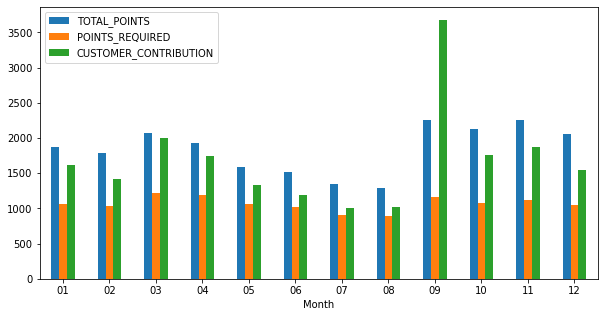

In [28]:
DATE = dfmonth.plot.bar(rot=0,figsize=(10, 5))

Text(0, 0.5, 'Points Required for Prize')

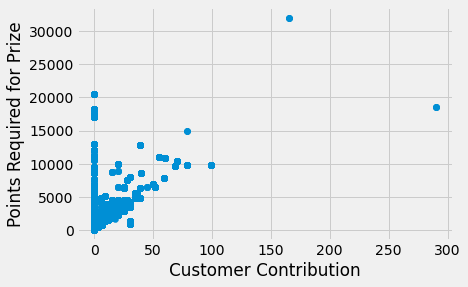

In [92]:
plt.scatter(df['CUSTOMER_CONTRIBUTION'],df['POINTS_REQUIRED'])
plt.xlabel("Customer Contribution")
plt.ylabel("Points Required for Prize")

In [16]:
dfclust = df[['TOTAL_POINTS','POINTS_REQUIRED']].copy()
dfclust

        POINTS_REQUIRED  TOTAL_POINTS
0                1800.0        3997.0
1                1800.0        3997.0
2                1800.0        3997.0
3                1800.0        3997.0
4                 450.0        5279.0
...                 ...           ...
501444           2395.0         111.0
501445           3500.0        9590.0
501446           4200.0         111.0
501447           4175.0        1041.0
501448           1750.0         180.0

[501449 rows x 2 columns]


In [17]:
dfclust = dfclust.replace(r'^\s*$', np.nan, regex=True)
dfclust

,POINTS_REQUIRED,TOTAL_POINTS
0,1800.0,3997.0
1,1800.0,3997.0
2,1800.0,3997.0
3,1800.0,3997.0
4,450.0,5279.0
...,...,...
501444,2395.0,111.0
501445,3500.0,9590.0
501446,4200.0,111.0
501447,4175.0,1041.0


In [18]:
dfclust.describe()

,POINTS_REQUIRED,TOTAL_POINTS
count,501220.000000,478422.000000
mean,1069.855774,1848.010482
std,1461.741644,3378.955683
min,0.000000,-6951.000000
25%,430.000000,331.000000
50%,430.000000,801.000000
75%,800.000000,2051.000000
max,32000.000000,168010.000000


In [19]:
dfclust.mean(axis = 0)

POINTS_REQUIRED    1069.855774
TOTAL_POINTS       1848.010482
dtype: float64

In [20]:
type(df['POINTS_REQUIRED'])

pandas.core.series.Series

In [21]:
def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

In [22]:
standardize(dfclust['TOTAL_POINTS']).describe()

count    4.784220e+05
mean    -4.330077e-17
std      1.000000e+00
min     -2.604062e+00
25%     -4.489584e-01
50%     -3.098622e-01
75%      6.007463e-02
max      4.917555e+01
Name: TOTAL_POINTS, dtype: float64

In [23]:
dfclust[['TOTAL_POINTS', 'POINTS_REQUIRED']] = dfclust[['TOTAL_POINTS', 'POINTS_REQUIRED']].fillna(0)
dfclust.head(500)

,POINTS_REQUIRED,TOTAL_POINTS
0,1800.0,3997.0
1,1800.0,3997.0
2,1800.0,3997.0
3,1800.0,3997.0
4,450.0,5279.0
...,...,...
495,850.0,0.0
496,1900.0,9597.0
497,850.0,0.0
498,430.0,410.0


In [24]:
dfclust["POINTS_REQUIRED"] = (dfclust["POINTS_REQUIRED"]-dfclust["POINTS_REQUIRED"].mean())/dfclust["POINTS_REQUIRED"].std()
dfclust

,POINTS_REQUIRED,TOTAL_POINTS
0,0.499890,3997.0
1,0.499890,3997.0
2,0.499890,3997.0
3,0.499890,3997.0
4,-0.423764,5279.0
...,...,...
501444,0.906982,111.0
501445,1.663010,9590.0
501446,2.141941,111.0
501447,2.124837,1041.0


In [25]:
dfclust["TOTAL_POINTS"] = (dfclust["TOTAL_POINTS"]-dfclust["TOTAL_POINTS"].mean())/dfclust["TOTAL_POINTS"].std()
dfclust

,POINTS_REQUIRED,TOTAL_POINTS
0,0.499890,0.672229
1,0.499890,0.672229
2,0.499890,0.672229
3,0.499890,0.672229
4,-0.423764,1.058019
...,...,...
501444,0.906982,-0.497178
501445,1.663010,2.355321
501446,2.141941,-0.497178
501447,2.124837,-0.217315


In [26]:
scaled_features = dfclust[['TOTAL_POINTS', 'POINTS_REQUIRED']]

In [27]:
scaled_features[:10]

,TOTAL_POINTS,POINTS_REQUIRED
0,0.672229,0.499890
1,0.672229,0.499890
2,0.672229,0.499890
3,0.672229,0.499890
4,1.058019,-0.423764
5,-0.157430,0.397262
6,2.282496,-0.437447
7,-0.451738,-0.437447
8,-0.455349,-0.437447
9,-0.385233,0.568309


Text(0, 0.5, 'Points Required for Prize')

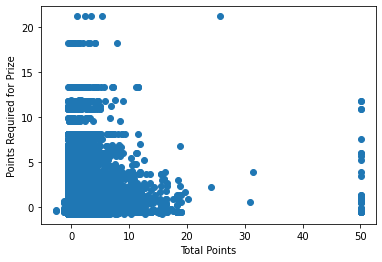

In [28]:
plt.scatter(dfclust['TOTAL_POINTS'],dfclust['POINTS_REQUIRED'])
plt.xlabel("Total Points")
plt.ylabel("Points Required for Prize")
# plt.xlim(0, 20)
# plt.ylim(0, 10)

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [30]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [31]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=42)

In [32]:
# The lowest SSE value
kmeans.inertia_

431524.5204810581

In [33]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[ 3.43456142,  0.25661184],
       [ 0.27810258,  2.42188268],
       [-0.18849776, -0.28054977]])

In [34]:
# The number of iterations required to converge
kmeans.n_iter_

15

In [35]:
kmeans.labels_[:5]

array([2, 2, 2, 2, 2], dtype=int32)

In [36]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 50,
    "max_iter": 300,
    "random_state": 123,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

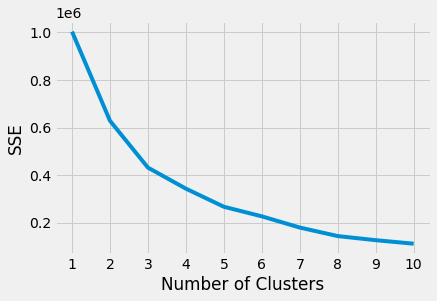

In [37]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [38]:
# LONG RUN TIME
## RETURNS: 
# silhouette_coefficients = 
# [0.7085531105839455,
# 0.7187792454835912,
# 0.6460204367244979,
# 0.6659870596782779,
# 0.6538089058808171,
# 0.62844855649615,
# 0.6427180296047984,
# 0.6010462452454745,
# 0.602342587186799]

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)

    silhouette_coefficients.append(score)

In [39]:
silhouette_coefficients

[0.7085531105839455,
 0.7187792454835912,
 0.6460204367244979,
 0.6659870596782779,
 0.6538089058808171,
 0.62844855649615,
 0.6427180296047984,
 0.6010462452454745,
 0.602342587186799]

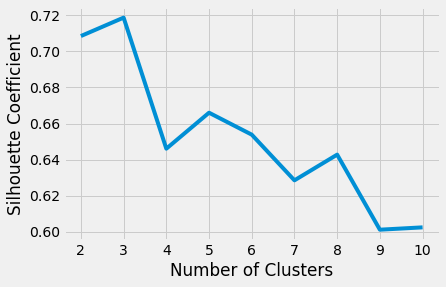

In [40]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [41]:
kmeans = KMeans(n_clusters= 3)

In [42]:
label = kmeans.fit_predict(scaled_features)

In [43]:
print(label)

[1 1 1 ... 2 2 1]


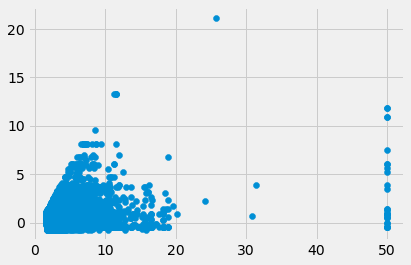

In [44]:
filtered_label0 = scaled_features[label == 0].values

plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

In [45]:
filtered_label1 = scaled_features[label == 1].values
 
filtered_label2 = scaled_features[label == 2].values

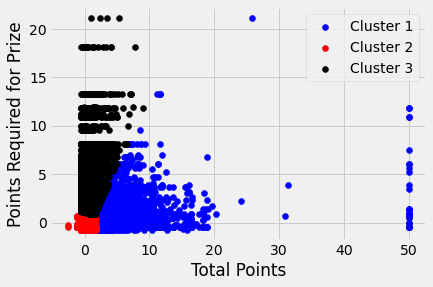

In [46]:
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'blue', label = "Cluster 1")
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'red', label = "Cluster 2")
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'black', label = "Cluster 3")
plt.legend(loc="upper right")
plt.xlabel("Total Points")
plt.ylabel("Points Required for Prize")
plt.show()

In [47]:
dfmale = df[df['SEX']== "M"] 
dffemale = df[df['SEX']=="F"]

In [48]:
dfmale

,CUSTOMER_CODE,REQUEST_PLACE,CATEGORY,MATERIAL_GROUPING,PRIZE_DESCRIPTION,POINTS_REQUIRED,CUSTOMER_CONTRIBUTION,DATE,TIME,SEX,DOB,REGION,PROVINCE,CITY,TYPE_OF_CARD,TOTAL_POINTS,DATE_JOINED
0,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:16:21,M,1978-09-28 00:00:00,SICILIA,MESSINA,MESSINA,STARQ8_FISICA,3997.0,2013-05-13 09:16:29
1,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:17:30,M,1978-09-28 00:00:00,SICILIA,MESSINA,MESSINA,STARQ8_FISICA,3997.0,2013-05-13 09:16:29
2,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:18:49,M,1978-09-28 00:00:00,SICILIA,MESSINA,MESSINA,STARQ8_FISICA,3997.0,2013-05-13 09:16:29
3,7071161603670014604,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN,2020-09-01,00:19:42,M,1978-09-28 00:00:00,SICILIA,MESSINA,MESSINA,STARQ8_FISICA,3997.0,2013-05-13 09:16:29
4,7071161603014051338,PUNTO VENDITA,PREMIO FISICO,PER TE,PRENOTAZIONE PORTA CARTE CREDITO SPARCO,450.0,0.0,2020-09-01,00:34:24,M,1967-09-02 00:00:00,SICILIA,PALERMO,CEFALU',STARQ8_FISICA,5279.0,2001-10-05 11:34:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501444,7071161603014068530,PUNTO VENDITA,PREMIO FISICO,ELETTRODOMESTICI,PRENOTAZIONE PHILIPS RASOIO,2395.0,0.0,2021-08-31,23:14:00,M,1975-07-11 00:00:00,NaN,NaN,NaN,STARQ8_FISICA,111.0,2017-07-04 13:00:40
501445,7071161603670271808,PUNTO VENDITA,PREMIO FISICO,MODA,PRENOTAZIONE OROLOGIO SECTOR,3500.0,30.0,2021-08-31,23:14:59,M,1977-11-29 00:00:00,CAMPANIA,NAPOLI,NAPOLI,STARQ8_FISICA,9590.0,2012-11-08 10:28:34
501446,7071161603014068530,PUNTO VENDITA,PREMIO FISICO,ELETTRONICA,PRENOTAZIONE AVVITATORE,4200.0,15.0,2021-08-31,23:15:02,M,1975-07-11 00:00:00,NaN,NaN,NaN,STARQ8_FISICA,111.0,2017-07-04 13:00:40
501447,7071161603007816325,PUNTO VENDITA,PREMIO FISICO,CASA,PRENOTAZIONE PORTABIANCHERIA,4175.0,0.0,2021-08-31,23:24:29,M,1967-11-13 00:00:00,MARCHE,ANCONA,ANCONA,STARQ8_FISICA,1041.0,2015-08-28 15:56:15


In [49]:
dffemale

,CUSTOMER_CODE,REQUEST_PLACE,CATEGORY,MATERIAL_GROUPING,PRIZE_DESCRIPTION,POINTS_REQUIRED,CUSTOMER_CONTRIBUTION,DATE,TIME,SEX,DOB,REGION,PROVINCE,CITY,TYPE_OF_CARD,TOTAL_POINTS,DATE_JOINED
5,7071161603019207497,PUNTO VENDITA,PREMIO FISICO,PER IL TUO BENESSERE,PRENOTAZIONE BILANCIA BODYMASTER ROWENTA,1650.0,8.0,2020-09-01,02:34:45,F,1978-10-27 00:00:00,SICILIA,PALERMO,PALERMO,STARQ8_FISICA,1240.0,2019-11-10 11:14:03
16,7071161603012857264,PUNTO VENDITA,PREMIO FISICO,PER TE,PRENOTAZIONE IDROPULITRICE K2 BASIC KARCHER,4900.0,6.0,2020-09-01,06:46:34,F,1976-04-10 00:00:00,SICILIA,CATANIA,BRONTE,STARQ8_FISICA,2769.0,2015-02-26 16:00:55
23,7071161603015746902,PUNTO VENDITA,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE SET PENTOLE BY LUCA TRAZZI,2100.0,NaN,2020-09-01,06:59:41,F,1989-11-17 00:00:00,ABRUZZO,CHIETI,ATESSA,STARQ8_FISICA,3039.0,2001-10-19 09:52:00
30,7071161603010278711,PUNTO VENDITA,BUONO SCONTO CARBURANTE,BUONO SCONTO CARBURANTE,BUONO SCONTO CARB 4E 430 PUNTI,430.0,0.0,2020-09-01,07:04:40,F,1978-01-02 00:00:00,CAMPANIA,NAPOLI,NAPOLI,STARQ8_FISICA,5538.0,2017-10-28 13:19:46
32,7071161603670225697,PUNTO VENDITA,PREMIO FISICO,PER LA TUA CASA,PRENOTAZIONE GUZZINI BORSA TERMICA,700.0,2.0,2020-09-01,07:05:49,F,1961-09-29 00:00:00,PUGLIA,LECCE,LECCE,STARQ8_FISICA,135.0,2015-03-09 07:25:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501426,7071161603002501757,ONLINE,PREMIO FISICO,PER TE,CONSEGNA CODICE GIFT AMILON 5?,650.0,NaN,2021-08-31,22:08:39,F,1985-03-09 00:00:00,LOMBARDIA,MONZA E BRIANZA,MONZA,STARQ8_FISICA,193.0,2015-07-13 08:00:02
501428,7071161603670054998,ONLINE,PREMIO FISICO,TAVOLA & CUCINA,CONSEGNA CODICE SET PIATTI 18PZ,2100.0,NaN,2021-08-31,22:16:10,F,1963-06-13 00:00:00,SICILIA,PALERMO,CAMPOFELICE DI ROCCELLA,STARQ8_FISICA,3431.0,2018-11-03 10:43:21
501429,7071161603000468967,PUNTO VENDITA,PREMIO FISICO,PER LA TUA CASA,PRENOTAZIONE BICCHIERE GUZZINI 4PZ,350.0,0.0,2021-08-31,22:21:54,F,1985-02-13 00:00:00,BASILICATA,POTENZA,CHIAROMONTE,STARQ8_FISICA,1405.0,2017-09-01 18:11:12
501431,7071161603002501757,ONLINE,PREMIO FISICO,PER TE,CONSEGNA CODICE GIFT AMILON 5?,650.0,NaN,2021-08-31,22:30:40,F,1985-03-09 00:00:00,LOMBARDIA,MONZA E BRIANZA,MONZA,STARQ8_FISICA,193.0,2015-07-13 08:00:02


Text(0, 0.5, 'Points Required for Prize')

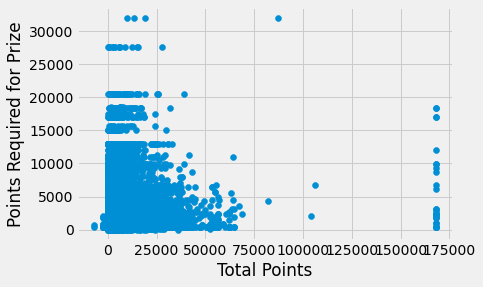

In [50]:
plt.scatter(dfmale['TOTAL_POINTS'],dfmale['POINTS_REQUIRED'])
plt.xlabel("Total Points")
plt.ylabel("Points Required for Prize")

Text(0, 0.5, 'Points Required for Prize')

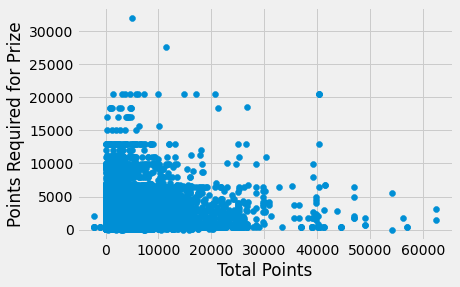

In [51]:
plt.scatter(dffemale['TOTAL_POINTS'],dffemale['POINTS_REQUIRED'])
plt.xlabel("Total Points")
plt.ylabel("Points Required for Prize")

In [52]:
dfmale['TOTAL_POINTS'].mean()

2007.5562398336856

In [53]:
dffemale['TOTAL_POINTS'].mean()

1435.9128816529494

In [54]:
dfmale['POINTS_REQUIRED'].mean()

1113.7990078472897

In [55]:
dffemale['POINTS_REQUIRED'].mean()

936.9228591118836

In [56]:
df['REGION'].unique()

array(['SICILIA', nan, 'CAMPANIA', 'PUGLIA', 'LOMBARDIA', 'ABRUZZO',
       'LAZIO', 'SARDEGNA', 'PIEMONTE', 'TOSCANA', 'CALABRIA',
       'EMILIA ROMAGNA', 'FRIULI VENEZIA GIULIA', 'VENETO', 'UMBRIA',
       'TRENTINO ALTO ADIGE', 'LIGURIA', 'BASILICATA', 'MARCHE', 'MOLISE',
       "VALLE D'AOSTA"], dtype=object)

In [71]:
dfregion = df[['TOTAL_POINTS','POINTS_REQUIRED','REGION']].copy()
dfregion

,TOTAL_POINTS,POINTS_REQUIRED,REGION
0,3997.0,1800.0,SICILIA
1,3997.0,1800.0,SICILIA
2,3997.0,1800.0,SICILIA
3,3997.0,1800.0,SICILIA
4,5279.0,450.0,SICILIA
...,...,...,...
501444,111.0,2395.0,NaN
501445,9590.0,3500.0,CAMPANIA
501446,111.0,4200.0,NaN
501447,1041.0,4175.0,MARCHE


In [78]:
dfregion = dfregion.groupby(['REGION']).mean()
dfregion

,TOTAL_POINTS,POINTS_REQUIRED
REGION,,
ABRUZZO,1470.953428,903.260551
BASILICATA,1870.661056,1196.843284
CALABRIA,1803.643770,1146.076214
CAMPANIA,1808.673350,1012.685731
EMILIA ROMAGNA,1875.150554,1070.752847
FRIULI VENEZIA GIULIA,1220.074223,779.610981
LAZIO,1839.497668,1032.501575
LIGURIA,1945.405090,1096.293717
LOMBARDIA,1868.198225,1040.431292


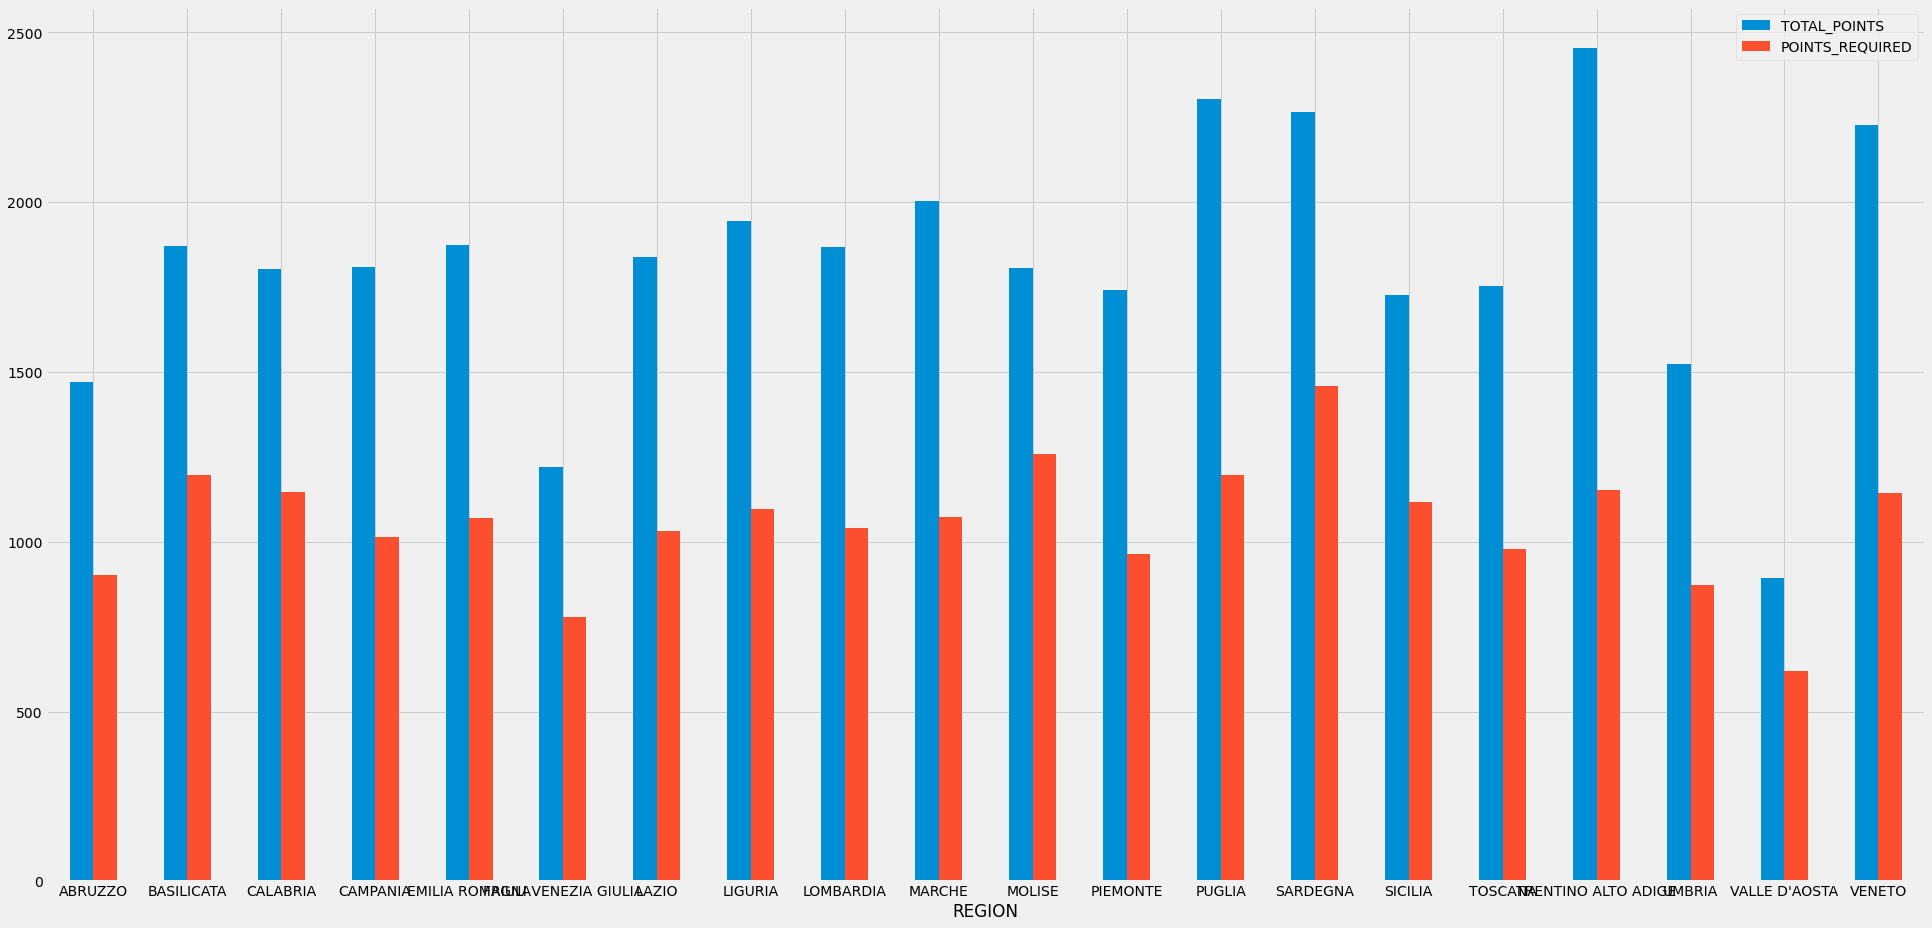

In [91]:
REGION = dfregion.plot.bar(rot=0,figsize=(30, 15))


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [42]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=3,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=123,
           ),
       ),
   ]
)

In [43]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

NameError: name 'preprocessor' is not defined

In [45]:
clusterer.fit(dfclust)

Pipeline(steps=[('kmeans',
                 KMeans(max_iter=500, n_clusters=3, n_init=50,
                        random_state=123))])